In [22]:
import pandas as pd
import numpy as np

# Visualization (optional but good)
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score


In [23]:
df = pd.read_csv("/content/pd_speech_features.csv")
df.head()


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240.0,239.0,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234.0,233.0,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232.0,231.0,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178.0,177.0,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236.0,235.0,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [24]:
df = pd.read_csv("/content/pd_speech_features.csv")
df.head()
df.shape

(756, 755)

In [25]:
df.shape

(756, 755)

In [26]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# Convert all columns to numeric, coercing errors to NaN
df_numeric = df.apply(pd.to_numeric, errors='coerce')

df_imputed = pd.DataFrame(
    imputer.fit_transform(df_numeric),
    columns=df_numeric.columns
)

In [27]:
df['class'].value_counts()


,count
class,
1,564
0,192


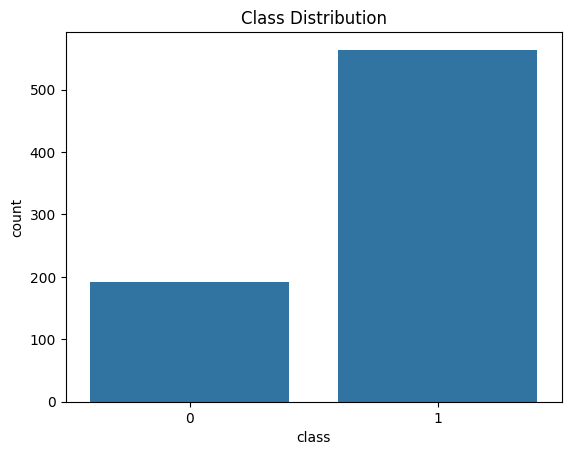

In [28]:
sns.countplot(x='class', data=df)
plt.title("Class Distribution")
plt.show()


In [39]:
X = df_imputed.drop(columns=['class'])
y = df_imputed['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [30]:
cv = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
)


In [31]:
log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])


In [32]:
svm = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='rbf', probability=True))
])


In [33]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)


In [40]:
scores_log_reg = cross_validate(log_reg, X_train, y_train, cv=cv, scoring=scoring)

print("Logistic Regression Cross-Validation Scores (per fold):")
for metric in scoring:
    print(f"{metric.capitalize()}: {scores_log_reg[f'test_{metric}']}")

Logistic Regression Cross-Validation Scores (per fold):
Accuracy: [0.8852459  0.85245902 0.78688525 0.86885246 0.81666667 0.8
 0.86666667 0.9        0.88333333 0.85      ]
Recall: [0.93478261 0.88888889 0.86666667 0.88888889 0.86666667 0.93333333
 0.88888889 0.93333333 0.95555556 0.93333333]
F1: [0.92473118 0.8988764  0.85714286 0.90909091 0.87640449 0.875
 0.90909091 0.93333333 0.92473118 0.90322581]
Roc_auc: [0.93913043 0.83472222 0.78888889 0.90833333 0.88888889 0.84888889
 0.94814815 0.93037037 0.85925926 0.87555556]


In [36]:
scoring = ['accuracy', 'recall', 'f1', 'roc_auc']

def cv_results(model, X, y):
    scores = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring
    )
    return {metric: scores[f'test_{metric}'].mean() for metric in scoring}


In [37]:
def test_results(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    return {
        'Acc': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    }


In [38]:
# Re-defining X and y using the imputed DataFrame
X = df_imputed.drop(columns=['class'])
y = df_imputed['class']

# Re-splitting the data to ensure X_train and y_train are updated with numeric features
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

cv_log = cv_results(log_reg, X_train, y_train)
cv_svm = cv_results(svm, X_train, y_train)
cv_xgb = cv_results(xgb, X_train, y_train)

cv_log, cv_svm, cv_xgb

({'accuracy': np.float64(0.8510109289617486),
  'recall': np.float64(0.9090338164251207),
  'f1': np.float64(0.9011627079577422),
  'roc_auc': np.float64(0.8822185990338165)},
 {'accuracy': np.float64(0.8592622950819673),
  'recall': np.float64(0.9845410628019323),
  'f1': np.float64(0.9130512948388747),
  'roc_auc': np.float64(0.8705322061191627)},
 {'accuracy': np.float64(0.8924043715846995),
  'recall': np.float64(0.9844444444444445),
  'f1': np.float64(0.9323078253751316),
  'roc_auc': np.float64(0.9512028985507248)})

In [41]:
test_log = test_results(log_reg)
test_svm = test_results(svm)
test_xgb = test_results(xgb)

results_df = pd.DataFrame([
    ['Logistic Regression', *test_log.values()],
    ['SVM', *test_svm.values()],
    ['XGBoost', *test_xgb.values()]
], columns=['Model', 'Accuracy', 'Recall', 'F1-Score', 'AUC-ROC'])

print("Test Set Results:")
print(results_df)

Test Set Results:
                 Model  Accuracy    Recall  F1-Score   AUC-ROC
0  Logistic Regression  0.855263  0.938053  0.905983  0.848310
1                  SVM  0.822368  0.964602  0.889796  0.874518
2              XGBoost  0.875000  0.973451  0.920502  0.927388


In [42]:
def test_results(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    return {
        'Acc': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    }


In [43]:
test_log = test_results(log_reg)
test_svm = test_results(svm)
test_xgb = test_results(xgb)


In [44]:
results = pd.DataFrame([
    ['Logistic Regression', *test_log.values()],
    ['SVM', *test_svm.values()],
    ['XGBoost', *test_xgb.values()]
], columns=['Model', 'Acc', 'Recall', 'F1', 'AUC'])

results


,Model,Acc,Recall,F1,AUC
0,Logistic Regression,0.855263,0.938053,0.905983,0.848310
1,SVM,0.822368,0.964602,0.889796,0.874518
2,XGBoost,0.875000,0.973451,0.920502,0.927388


In [48]:
!pip install qiskit qiskit-machine-learning qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 71.9 MB/s eta 0:00:00


In [53]:
from qiskit_aer import Aer
# from qiskit.utils import QuantumInstance # Deprecated in Qiskit 1.0+
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN

In [55]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)  # 2–6 is realistic
X_train_q = pca.fit_transform(X_train)
X_test_q = pca.transform(X_test)


In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler_q = MinMaxScaler(feature_range=(0, np.pi))
X_train_q = scaler_q.fit_transform(X_train_q)
X_test_q = scaler_q.transform(X_test_q)


In [62]:
from qiskit_aer.primitives import Sampler # Import Sampler from aer.primitives
backend = Aer.get_backend('aer_simulator') # Get the Aer backend

# Define the feature map with the appropriate dimension
feature_map = ZZFeatureMap(feature_dimension=X_train_q.shape[1], reps=2)

# Initialize a Sampler primitive using the Aer backend
sampler = Sampler() # Removed 'shots=1024'

# Define the quantum kernel using FidelityQuantumKernel
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

/tmp/ipython-input-787319526.py:5: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=X_train_q.shape[1], reps=2)


In [63]:
feature_map = ZZFeatureMap(
    feature_dimension=X_train_q.shape[1],
    reps=2
)


/tmp/ipython-input-2871294626.py:1: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(


In [68]:
quantum_kernel = FidelityQuantumKernel(
    feature_map=feature_map
)

In [69]:
qsvm = QSVC(quantum_kernel=quantum_kernel)

qsvm.fit(X_train_q, y_train)


QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x7b289456cb60>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [70]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

y_pred_qsvm = qsvm.predict(X_test_q)

qsvm_results = {
    'Acc': accuracy_score(y_test, y_pred_qsvm),
    'Recall': recall_score(y_test, y_pred_qsvm),
    'F1': f1_score(y_test, y_pred_qsvm)
}

qsvm_results


{'Acc': 0.756578947368421,
 'Recall': 0.9734513274336283,
 'F1': 0.8560311284046692}

In [71]:
ansatz = TwoLocal(
    num_qubits=X_train_q.shape[1],
    rotation_blocks='ry',
    entanglement_blocks='cz',
    reps=2
)


/tmp/ipython-input-1024602680.py:1: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(


In [73]:
from qiskit.circuit import QuantumCircuit

# Get the number of qubits from the feature map or ansatz
num_qubits = X_train_q.shape[1] # Should be 4 based on X_train_q

# Create a combined circuit by composing the feature map and ansatz
combined_circuit = QuantumCircuit(num_qubits)
combined_circuit.compose(feature_map, inplace=True)
combined_circuit.compose(ansatz, inplace=True)

qnn = EstimatorQNN(
    circuit=combined_circuit,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

In [78]:
!pip install --upgrade qiskit qiskit-algorithms # Ensure optimizers are available
from qiskit_algorithms.optimizers import COBYLA

vqc = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=COBYLA(maxiter=100),
    initial_point=np.random.rand(qnn.num_weights)
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 23.2 MB/s eta 0:00:00


In [79]:
vqc.fit(X_train_q, y_train)


In [81]:
y_pred_vqc = vqc.predict(X_test_q)

# Convert -1 to 0 in y_pred_vqc to match y_test labels
y_pred_vqc[y_pred_vqc == -1] = 0

vqc_results = {
    'Acc': accuracy_score(y_test, y_pred_vqc),
    'Recall': recall_score(y_test, y_pred_vqc),
    'F1': f1_score(y_test, y_pred_vqc)
}

vqc_results

{'Acc': 0.743421052631579,
 'Recall': 0.9734513274336283,
 'F1': 0.8494208494208494}

In [82]:
quantum_results = pd.DataFrame([
    ['QSVM', qsvm_results['Acc'], qsvm_results['Recall'], qsvm_results['F1'], 'N/A'],
    ['VQC/QNN', vqc_results['Acc'], vqc_results['Recall'], vqc_results['F1'], 'N/A']
], columns=['Model', 'Acc', 'Recall', 'F1', 'AUC'])

quantum_results


,Model,Acc,Recall,F1,AUC
0,QSVM,0.756579,0.973451,0.856031,N/A
1,VQC/QNN,0.743421,0.973451,0.849421,N/A
